#  LSTM FORESCASTING MODEL

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [2]:
#loading the data previusly cleaned in pyspark
air_quality = pd.read_csv("clean_quality_data.csv")

In [3]:
#checking the data
air_quality.head()

,Estación,Título,latitud,longitud,Fecha,Periodo,SO2,NO,NO2,PM10,O3,dd,vv,TMP,HR,PRB,RS,LL,PM25
0,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,24,1,2,12,23,86.0,175.0,1.46,10.6,44.0,1017.0,56,0.0,10
1,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,23,1,1,7,24,97.0,181.0,1.71,10.8,44.0,1017.0,56,0.0,6
2,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,22,1,1,12,17,88.0,174.0,1.37,10.6,46.0,1017.0,56,0.0,7
3,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,21,1,4,26,29,71.0,182.0,1.57,10.6,47.0,1016.0,56,0.0,5
4,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,20,1,4,27,29,69.0,176.0,1.64,10.9,45.0,1016.0,56,0.0,4


In [4]:
#checking number of observations and variables in dataset
air_quality.shape

(43800, 19)

In [5]:
#Confirming there is not missing values
air_quality.isnull().sum()

Estación    0
Título      0
latitud     0
longitud    0
Fecha       0
Periodo     0
SO2         0
NO          0
NO2         0
PM10        0
O3          0
dd          0
vv          0
TMP         0
HR          0
PRB         0
RS          0
LL          0
PM25        0
dtype: int64

## LSTM TIMES SERIES FORESCASTING - PM10 VALUE

In [6]:
# changing'Periodo' represents hours as integers, convert them to hour format
air_quality['Periodo'] = pd.to_datetime(air_quality['Periodo'], format='%H', errors='coerce').dt.strftime('%H:%M')

# Remove rows with null values in 'Periodo', which could not be converted properly
air_quality = air_quality.dropna(subset=['Periodo'])

# Concatenate 'Fecha' and 'Periodo' with the desired format
air_quality['Fecha_Periodo'] = air_quality['Fecha'] + ' ' + air_quality['Periodo']


In [7]:
#verifing new variable  Fecha_Periodo was created
air_quality.head()

,Estación,Título,latitud,longitud,Fecha,Periodo,SO2,NO,NO2,PM10,O3,dd,vv,TMP,HR,PRB,RS,LL,PM25,Fecha_Periodo
1,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,23:00,1,1,7,24,97.0,181.0,1.71,10.8,44.0,1017.0,56,0.0,6,31/12/2023 23:00
2,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,22:00,1,1,12,17,88.0,174.0,1.37,10.6,46.0,1017.0,56,0.0,7,31/12/2023 22:00
3,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,21:00,1,4,26,29,71.0,182.0,1.57,10.6,47.0,1016.0,56,0.0,5,31/12/2023 21:00
4,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,20:00,1,4,27,29,69.0,176.0,1.64,10.9,45.0,1016.0,56,0.0,4,31/12/2023 20:00
5,1,Estación Avenida Constitución,43.529806,-5.673428,31/12/2023,19:00,1,5,35,32,63.0,177.0,1.36,11.0,43.0,1016.0,56,0.0,4,31/12/2023 19:00


In [8]:
# Convert 'Fecha_Periodo' column to datetime format with the correct format string
air_quality.index = pd.to_datetime(air_quality["Fecha_Periodo"], format="%d/%m/%Y %H:%M")

In [9]:
#creating new dataframe with "pm10"
pm10 = air_quality["PM10"]

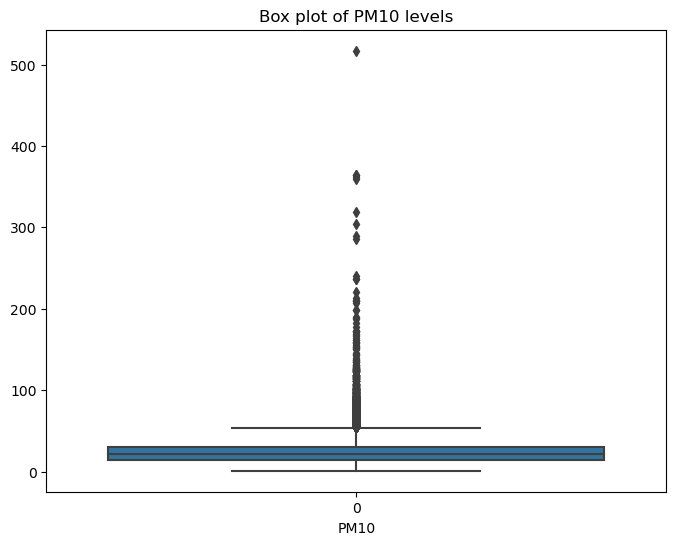

In [10]:
#checking outliers

plt.figure(figsize=(8, 6))
sns.boxplot(data=pm10)
plt.title('Box plot of PM10 levels')
plt.xlabel('PM10')
plt.show()

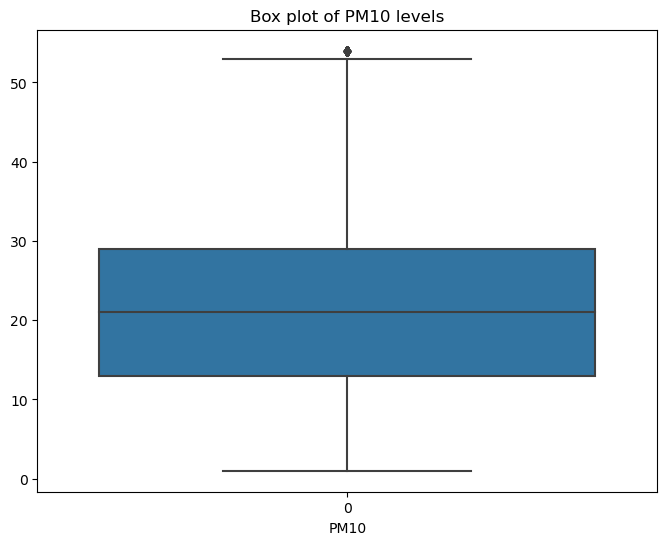

In [11]:
#cleaning outliers

# Calculate the first quartile (Q1)
Q1 = np.percentile(pm10, 25)

# Calculate the third quartile (Q3)
Q3 = np.percentile(pm10, 75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
pm10 = pm10[(pm10>= lower_bound) & (pm10 <= upper_bound)]

#checking outliers after cleaning

plt.figure(figsize=(8, 6))
sns.boxplot(data=pm10)
plt.title('Box plot of PM10 levels')
plt.xlabel('PM10')
plt.show()


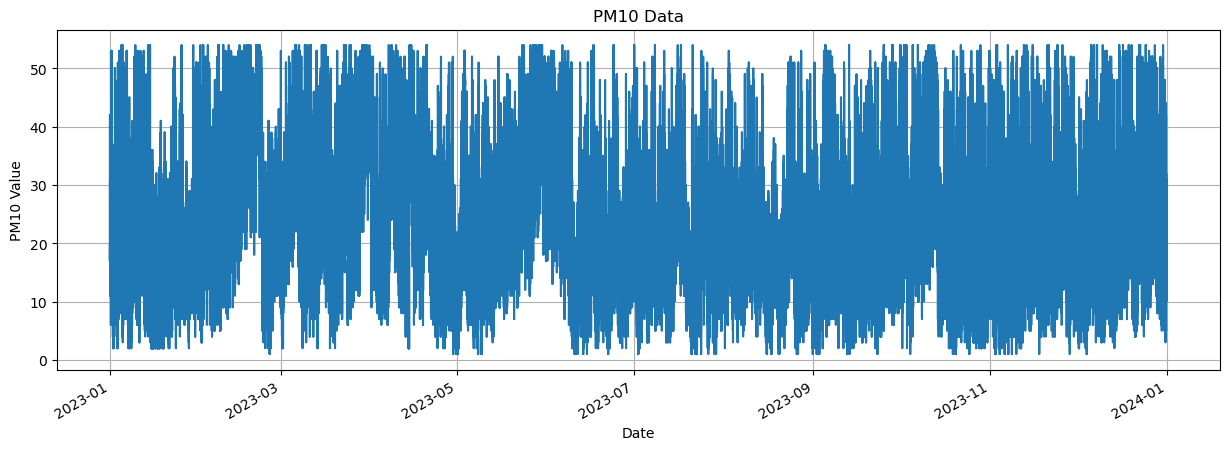

In [12]:
#Plotting timeseries of pm10 value

plt.figure(figsize=(15, 5))  # Adjust the width and height as needed
pm10.plot()
plt.title('PM10 Data')  # Adding a title to the plot
plt.xlabel('Date')  # Adding label for x-axis
plt.ylabel('PM10 Value')  # Adding label for y-axis
plt.grid(True)  # Adding grid lines
plt.show()

In [13]:
#defining the function to prepare the data for a supervised learning task predicting pm10 - where you predict the next value in a time series based on a window of past values
def air_quality_to_X_y(air_quality, window_size=5):
    air_quality_as_np = air_quality.to_numpy()
    X = []
    y = []
    for i in range(len(air_quality_as_np) - window_size):
        row = [[a] for a in air_quality_as_np[i:i+window_size]]
        X.append(row)
        label = air_quality_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [14]:
# Assigning window size "10"
window_size = 5
X, y = air_quality_to_X_y(pm10, window_size)
X.shape, y.shape

((40185, 5, 1), (40185,))

In [15]:
# Splitting the data

X_train, y_train = X[:30000], y[:30000]  # Select the first 30000 samples for training
X_val, y_val = X[30000:40000], y[30000:40000]  # Select the next 10000 samples for validation
X_test, y_test = X[40000:], y[40000:]  # The remaining samples are used for testing
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((30000, 5, 1), (30000,), (10000, 5, 1), (10000,), (185, 5, 1), (185,))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.metrics import MeanAbsoluteError


## Model 1 MeanSquaredLogarithmicError()

In [17]:
#compiling the model

model1 =Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM((64)))
model1.add(Dense(8,"relu"))
model1.add(Dense(1,"linear"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


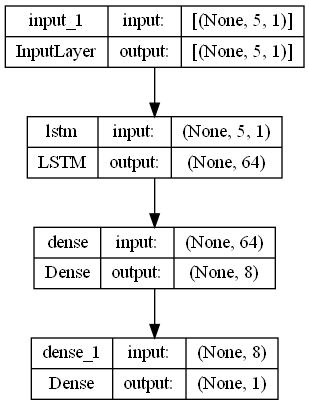

In [18]:
from tensorflow.keras.utils import plot_model

#Creating a diagram of the model architecture
plot_model(model1, to_file='model1_architecture.png', show_shapes=True)

In [19]:
from tensorflow.keras.metrics import Accuracy

# Define el callback ModelCheckpoint
checkpoint = ModelCheckpoint("model1/", save_best_only=True)
model1.compile(loss=MeanSquaredLogarithmicError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])


In [20]:
# Training the model
history=model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
911/938 [============================>.] - ETA: 0s - loss: 0.4397 - mean_absolute_error: 8.1498INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 5s 4ms/step - loss: 0.4313 - mean_absolute_error: 8.0840 - val_loss: 0.1171 - val_mean_absolute_error: 5.5294
Epoch 2/10
938/938 [==============================] - ETA: 0s - loss: 0.1215 - mean_absolute_error: 5.4973INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1215 - mean_absolute_error: 5.4973 - val_loss: 0.1137 - val_mean_absolute_error: 5.3026
Epoch 3/10
921/938 [============================>.] - ETA: 0s - loss: 0.1193 - mean_absolute_error: 5.3569INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1190 - mean_absolute_error: 5.3520 - val_loss: 0.1108 - val_mean_absolute_error: 5.1532
Epoch 4/10
921/938 [============================>.] - ETA: 0s - loss: 0.1184 - mean_absolute_error: 5.3151INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1183 - mean_absolute_error: 5.3135 - val_loss: 0.1101 - val_mean_absolute_error: 5.0784
Epoch 5/10
913/938 [============================>.] - ETA: 0s - loss: 0.1182 - mean_absolute_error: 5.2981INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


938/938 [==============================] - 4s 4ms/step - loss: 0.1180 - mean_absolute_error: 5.2922 - val_loss: 0.1095 - val_mean_absolute_error: 5.0782
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1179 - mean_absolute_error: 5.2815 - val_loss: 0.1107 - val_mean_absolute_error: 5.1107
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1176 - mean_absolute_error: 5.2773 - val_loss: 0.1129 - val_mean_absolute_error: 5.2382
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1173 - mean_absolute_error: 5.2707 - val_loss: 0.1130 - val_mean_absolute_error: 5.1485
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1172 - mean_absolute_error: 5.2715 - val_loss: 0.1103 - val_mean_absolute_error: 5.0964
Epoch 10/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1172 - mean_absolute_error: 5.2668 - val_loss: 0.1109 - val_mean_absolute_error: 5.0917


In [21]:
from tabulate import tabulate

# Extracting relevant information from the history object
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']

# Creating a list of dictionaries for tabulate
history_df = [{'Epochs': epoch, 'Loss': loss_val, 'Validation Loss': val_loss_val} for epoch, loss_val, val_loss_val in zip(epochs, loss, val_loss)]

# Print the table
print(tabulate(history_df, headers='keys', tablefmt='pretty'))

+--------+---------------------+---------------------+
| Epochs |        Loss         |   Validation Loss   |
+--------+---------------------+---------------------+
|   1    | 0.43126094341278076 | 0.11708860099315643 |
|   2    | 0.12149347364902496 | 0.11368145793676376 |
|   3    | 0.11897701770067215 | 0.11075976490974426 |
|   4    | 0.11832378804683685 | 0.11007475852966309 |
|   5    | 0.11797855794429779 | 0.10949957370758057 |
|   6    | 0.11789098381996155 | 0.11071031540632248 |
|   7    | 0.11761976778507233 | 0.11290766298770905 |
|   8    | 0.11733514070510864 | 0.11303990334272385 |
|   9    | 0.11721809953451157 | 0.11031991243362427 |
|   10   | 0.11723723262548447 | 0.11087524145841599 |
+--------+---------------------+---------------------+


In [22]:
# Extracting relevant information from the history object
epochs = range(1, len(history.history['loss']) + 1)
mean_absolute_error = history.history['mean_absolute_error']
val_mean_absolute_error = history.history['val_mean_absolute_error']

# Creating a DataFrame to store the results
history_df = pd.DataFrame({
    'Epochs': epochs,
    'Mean Absolute Error': mean_absolute_error,
    'Validation Mean Absolute Error': val_mean_absolute_error
})

# Print the DataFrame as a table
print(tabulate(history_df, headers='keys', tablefmt='pretty'))

+---+--------+---------------------+--------------------------------+
|   | Epochs | Mean Absolute Error | Validation Mean Absolute Error |
+---+--------+---------------------+--------------------------------+
| 0 |  1.0   |  8.083966255187988  |       5.529423713684082        |
| 1 |  2.0   |  5.497318267822266  |       5.302576541900635        |
| 2 |  3.0   |  5.351974010467529  |       5.1532416343688965       |
| 3 |  4.0   | 5.3134613037109375  |       5.078431606292725        |
| 4 |  5.0   |  5.292201519012451  |       5.078171253204346        |
| 5 |  6.0   |  5.281452655792236  |       5.110706329345703        |
| 6 |  7.0   |  5.277275085449219  |       5.238158702850342        |
| 7 |  8.0   |  5.270664215087891  |       5.148548126220703        |
| 8 |  9.0   |  5.271531105041504  |       5.096438884735107        |
| 9 |  10.0  |  5.266846656799316  |       5.091736316680908        |
+---+--------+---------------------+--------------------------------+


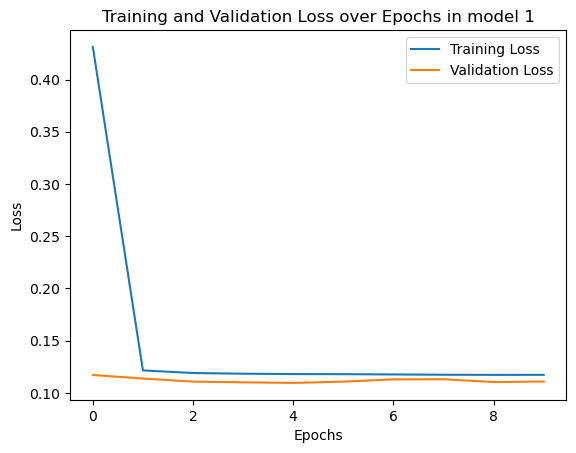

In [23]:
# Plotting the training and validation loss over epochs

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs in model 1')
plt.legend()
plt.savefig("Training and Validation Loss over Epochs in model 1.jpg")
plt.show()

In [24]:
from tensorflow.keras.models import load_model
model1 =load_model("model1/")

In [25]:
#Checking prediction and actual values for training data

train_predictions =model1.predict(X_train).flatten()
train_results =pd.DataFrame(data={"Train Predictions": train_predictions, "Actual" :y_train})
train_results

938/938 [==============================] - 1s 1ms/step


,Train Predictions,Actual
0,29.214104,27
1,26.243034,23
2,23.561951,24
3,23.675259,24
4,23.864931,16
...,...,...
29995,24.075918,26
29996,24.680933,20
29997,21.611965,52
29998,32.264774,41


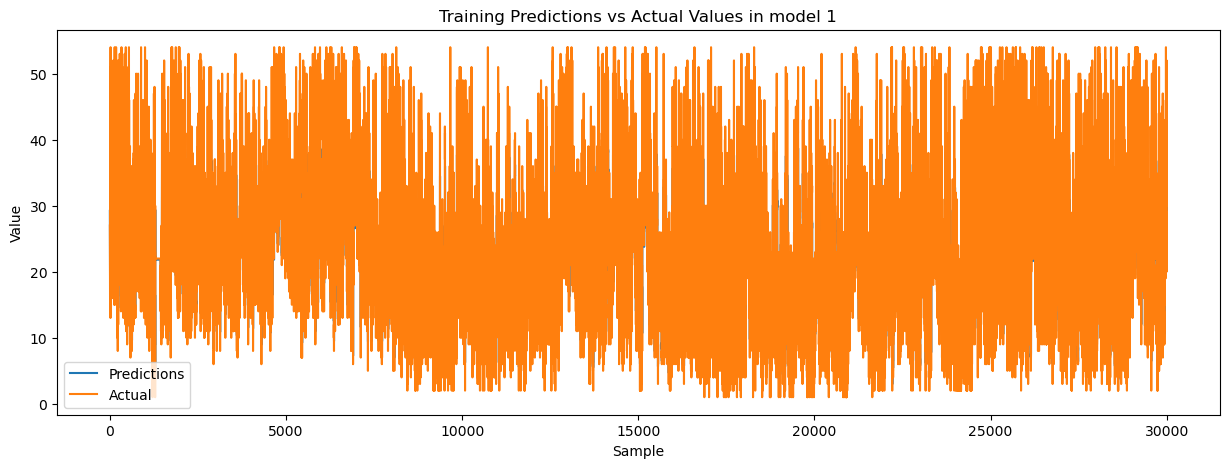

In [26]:
# Plot the model predictions and the actual values
plt.figure(figsize=(15, 5))
plt.plot(train_results["Train Predictions"], label="Predictions")
plt.plot(train_results["Actual"], label="Actual")

# Add labels and title to the plot

plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Training Predictions vs Actual Values in model 1")
plt.legend()

plt.savefig("Training Predictions vs Actual Values in model 1.jpg")

# Show the plot
plt.show()


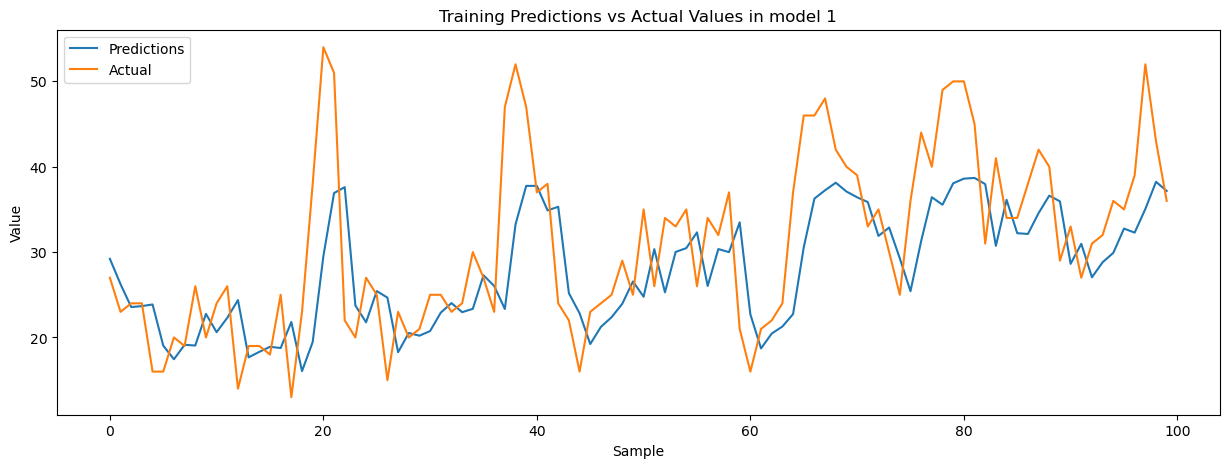

In [27]:
# Limit the number of points to display (for example, the first 100 points) to have a better perspective of the predictions
num_points = 100
train_results_subset = train_results.iloc[:num_points]

# Plot the model predictions and the actual values
plt.figure(figsize=(15, 5))
plt.plot(train_results_subset["Train Predictions"], label="Predictions")
plt.plot(train_results_subset["Actual"], label="Actual")

# Add labels and title to the plot
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Training Predictions vs Actual Values in model 1")
plt.legend()

plt.savefig("Training Predictions vs Actual Values in model 1.jpg")

# Show the plot
plt.show()


In [28]:
#Checking prediction and actual values for validation data
val_predictions =model1.predict(X_val).flatten()
val_results =pd.DataFrame(data={"Val Predictions": val_predictions, "Actual" :y_val})
val_results

313/313 [==============================] - 0s 1ms/step


,Val Predictions,Actual
0,28.841070,29
1,28.116825,35
2,32.250118,27
3,26.749865,19
4,21.283300,34
...,...,...
9995,26.020517,24
9996,23.726072,27
9997,25.132774,22
9998,22.859121,15


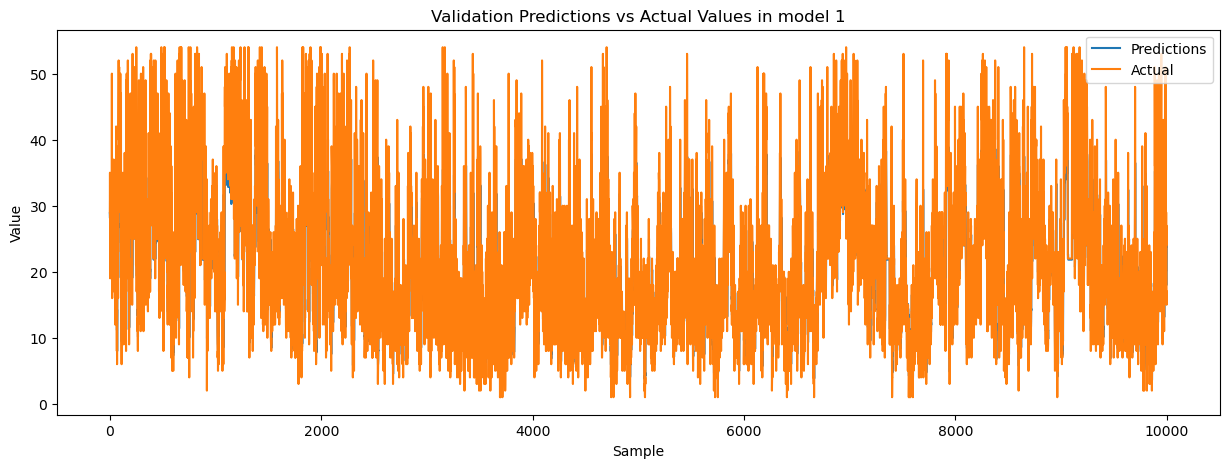

In [29]:
# Plot the model predictions and the actual values
plt.figure(figsize=(15, 5))
plt.plot(val_results["Val Predictions"], label="Predictions")
plt.plot(val_results["Actual"], label="Actual")

# Add labels and title to the plot

plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Validation Predictions vs Actual Values in model 1")
plt.legend()
#plt.savefig("Validation Predictions vs Actual Values in model 1.jpg")

# Show the plot
plt.show()


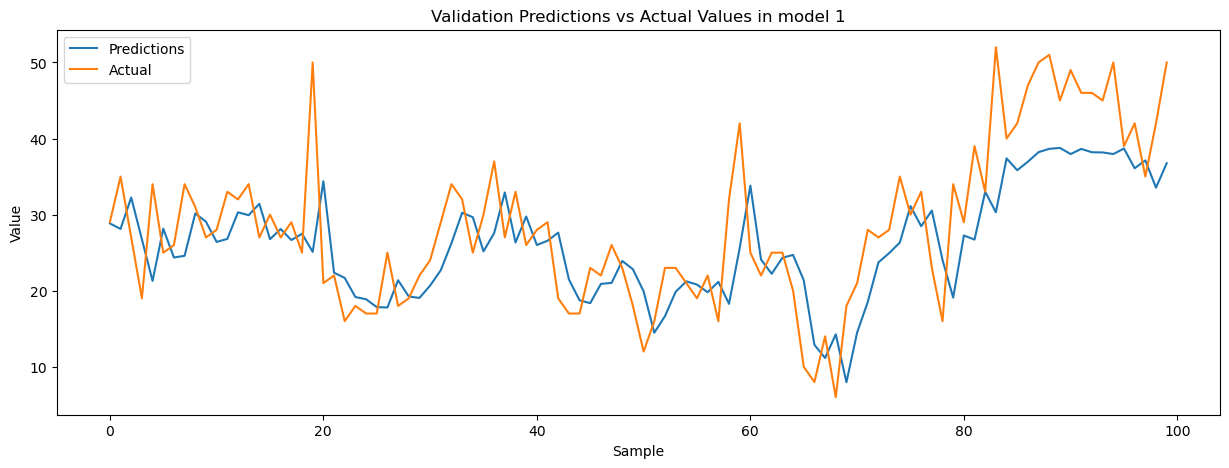

In [30]:
# Limit the number of points to display (for example, the first 50 points)
num_points = 100
val_results_subset = val_results.iloc[:num_points]

# Plot the model predictions and the actual values
plt.figure(figsize=(15, 5))
plt.plot(val_results_subset["Val Predictions"], label="Predictions")
plt.plot(val_results_subset["Actual"], label="Actual")

# Add labels and title to the plot
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Validation Predictions vs Actual Values in model 1")
plt.legend()

plt.savefig("Validation Predictions vs Actual Values in model 1.jpg")


# Show the plot
plt.show()


In [31]:
#Checking prediction and actual values for testing data
test_predictions =model1.predict(X_test).flatten()
test_results =pd.DataFrame(data={"Test Predictions": test_predictions, "Actual" :y_test})
test_results

6/6 [==============================] - 0s 1ms/step


,Test Predictions,Actual
0,17.921310,18
1,18.289894,14
2,15.835516,15
3,16.070848,18
4,17.495810,25
...,...,...
180,16.707912,19
181,18.099308,14
182,15.597878,11
183,12.906343,31


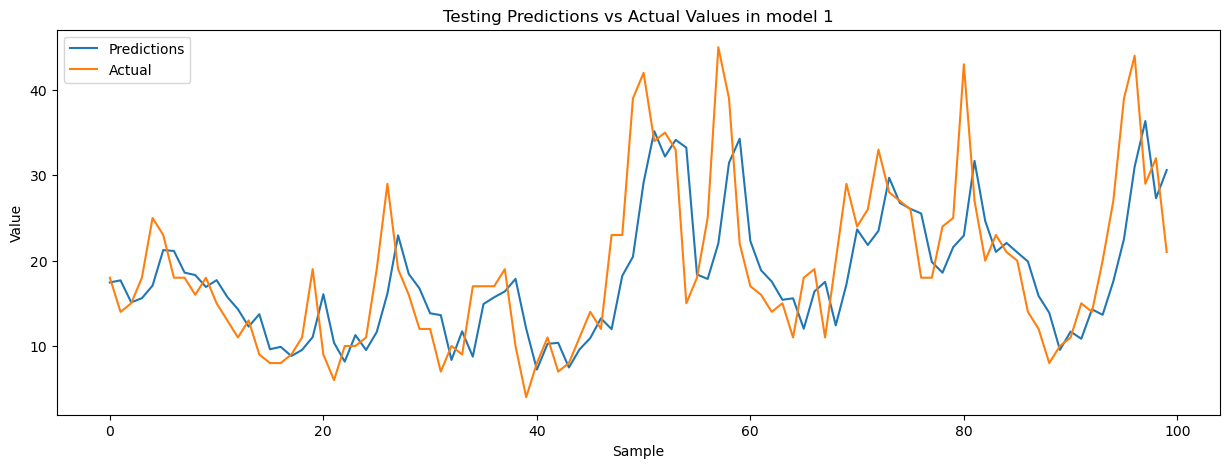

In [50]:
# Limit the number of points to display (for example, the first 50 points)
num_points = 100
test_results_subset = test_results.iloc[:num_points]

# Plot the model predictions and the actual values
plt.figure(figsize=(15, 5))
plt.plot(test_results_subset["Test Predictions"], label="Predictions")
plt.plot(test_results_subset["Actual"], label="Actual")

# Add labels and title to the plot
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Testing Predictions vs Actual Values in model 1")
plt.legend()

# Show the plot
plt.show()


## Modelo 2

In [57]:
from tensorflow.keras.layers import Dropout

# Define the model
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(LSTM(64, return_sequences=True))  # Adding an additional LSTM layer
model2.add(Dropout(0.2))  # Adding Dropout regularization
model2.add(LSTM(64))  # Another LSTM layer
model2.add(Dense(8, activation='relu'))  #  activation function to relu
model2.add(Dense(1, activation='linear'))


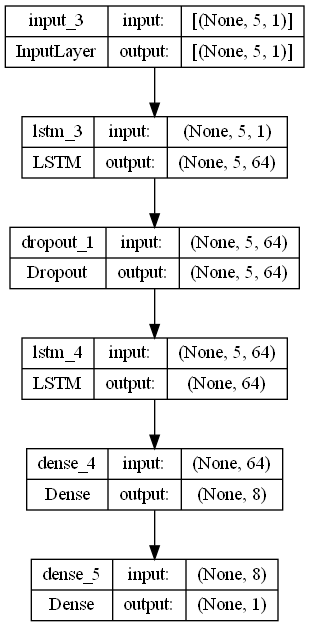

In [58]:
#Creating a diagram of the model architecture
plot_model(model2, to_file='model2_architecture.png', show_shapes=True)

In [59]:
# Compile the model with the RootMeanSquaredError metric# Define el callback ModelCheckpoint
checkpoint = ModelCheckpoint("model2/", save_best_only=True)

model2.compile(loss=MeanSquaredLogarithmicError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])

In [60]:
# Training the model 2
history=model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
930/938 [============================>.] - ETA: 0s - loss: 0.2744 - mean_absolute_error: 7.1116INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 9s 8ms/step - loss: 0.2731 - mean_absolute_error: 7.1027 - val_loss: 0.1187 - val_mean_absolute_error: 5.4003
Epoch 2/10
926/938 [============================>.] - ETA: 0s - loss: 0.1219 - mean_absolute_error: 5.4592INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


938/938 [==============================] - 7s 7ms/step - loss: 0.1217 - mean_absolute_error: 5.4569 - val_loss: 0.1106 - val_mean_absolute_error: 5.2031
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1204 - mean_absolute_error: 5.3714 - val_loss: 0.1118 - val_mean_absolute_error: 5.1390
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1197 - mean_absolute_error: 5.3509 - val_loss: 0.1188 - val_mean_absolute_error: 5.4455
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1193 - mean_absolute_error: 5.3339 - val_loss: 0.1115 - val_mean_absolute_error: 5.1312
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1186 - mean_absolute_error: 5.3325 - val_loss: 0.1112 - val_mean_absolute_error: 5.0859
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1192 - mean_absolute_error: 5.3404 - val_loss: 0.1123 - val_mean_absolute_error: 5.1053
Epoch 8/10
938/938 [=======

In [61]:
from tabulate import tabulate

# Extracting relevant information from the history object
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']

# Creating a list of dictionaries for tabulate
history_df = [{'Epochs': epoch, 'Loss': loss_val, 'Validation Loss': val_loss_val} for epoch, loss_val, val_loss_val in zip(epochs, loss, val_loss)]

# Print the table
print(tabulate(history_df, headers='keys', tablefmt='pretty'))

+--------+---------------------+---------------------+
| Epochs |        Loss         |   Validation Loss   |
+--------+---------------------+---------------------+
|   1    | 0.27314868569374084 | 0.11869111657142639 |
|   2    | 0.12170978635549545 | 0.11060189455747604 |
|   3    | 0.12039387971162796 | 0.11175046116113663 |
|   4    | 0.11968106031417847 | 0.1187916025519371  |
|   5    | 0.11934671550989151 | 0.1115080714225769  |
|   6    | 0.11862864345312119 | 0.11119448393583298 |
|   7    | 0.1191881000995636  | 0.11233614385128021 |
|   8    | 0.11862163245677948 | 0.11074553430080414 |
|   9    | 0.11865945160388947 | 0.11288720369338989 |
|   10   | 0.11863785237073898 | 0.11241782456636429 |
+--------+---------------------+---------------------+


In [62]:
# Extracting relevant information from the history object
epochs = range(1, len(history.history['loss']) + 1)
mean_absolute_error = history.history['mean_absolute_error']
val_mean_absolute_error = history.history['val_mean_absolute_error']

# Creating a DataFrame to store the results
history_df = pd.DataFrame({
    'Epochs': epochs,
    'Mean Absolute Error': mean_absolute_error,
    'Validation Mean Absolute Error': val_mean_absolute_error
})

# Print the DataFrame as a table
print(tabulate(history_df, headers='keys', tablefmt='pretty'))

+---+--------+---------------------+--------------------------------+
|   | Epochs | Mean Absolute Error | Validation Mean Absolute Error |
+---+--------+---------------------+--------------------------------+
| 0 |  1.0   |  7.102653503417969  |       5.400305271148682        |
| 1 |  2.0   |  5.45690393447876   |       5.203084945678711        |
| 2 |  3.0   |  5.371394157409668  |       5.139020919799805        |
| 3 |  4.0   |  5.350931167602539  |       5.445549964904785        |
| 4 |  5.0   |  5.333937644958496  |       5.131220817565918        |
| 5 |  6.0   |  5.332473278045654  |       5.085923671722412        |
| 6 |  7.0   |  5.340396881103516  |       5.105297088623047        |
| 7 |  8.0   |  5.317262172698975  |       5.1152262687683105       |
| 8 |  9.0   |  5.316159725189209  |       5.097456455230713        |
| 9 |  10.0  |  5.322665691375732  |        5.11533784866333        |
+---+--------+---------------------+--------------------------------+


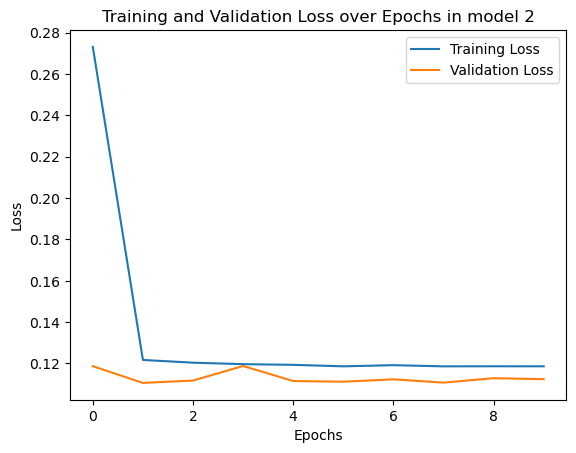

In [63]:
# Plotting the training and validation loss over epochs

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs in model 2')
plt.legend()

plt.savefig("Training and Validation Loss over Epochs in model 2")
plt.show()

In [65]:
from tensorflow.keras.models import load_model
model2 =load_model("model2/")

#Checking prediction and actual values for training data
train_predictions =model2.predict(X_train).flatten()
train_results =pd.DataFrame(data={"Train Predictions": train_predictions, "Actual" :y_train})
train_results

938/938 [==============================] - 2s 2ms/step


,Train Predictions,Actual
0,28.134045,27
1,25.784311,23
2,23.242685,24
3,22.994181,24
4,22.854252,16
...,...,...
29995,23.255621,26
29996,23.871517,20
29997,21.003748,52
29998,28.779692,41


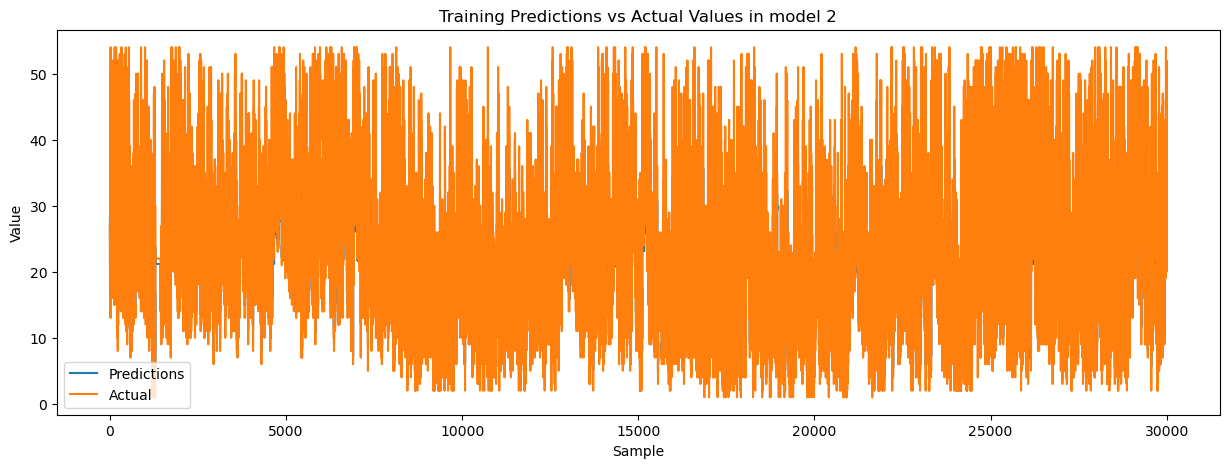

In [66]:
# Plot the model predictions and the actual values
plt.figure(figsize=(15, 5))
plt.plot(train_results["Train Predictions"], label="Predictions")
plt.plot(train_results["Actual"], label="Actual")

# Add labels and title to the plot

plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Training Predictions vs Actual Values in model 2")
plt.legend()

# Show the plot
plt.show()


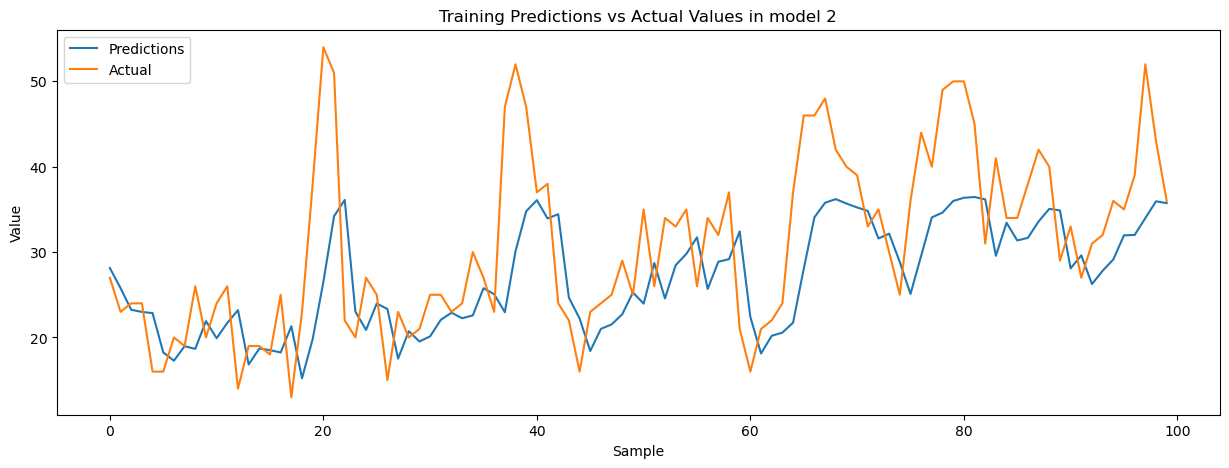

In [67]:
# Limit the number of points to display
num_points = 100
train_results_subset = train_results.iloc[:num_points]
plt.figure(figsize=(15, 5))

# Plot the model predictions and the actual values

plt.plot(train_results_subset["Train Predictions"], label="Predictions")
plt.plot(train_results_subset["Actual"], label="Actual")

# Add labels and title to the plot
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Training Predictions vs Actual Values in model 2")
plt.legend()
plt.savefig("Training Predictions vs Actual Values in model 2")

# Show the plot
plt.show()


In [68]:
#Checking prediction and actual values for validation data
val_predictions =model2.predict(X_val).flatten()
val_results =pd.DataFrame(data={"Val Predictions": val_predictions, "Actual" :y_val})
val_results

313/313 [==============================] - 0s 1ms/step


,Val Predictions,Actual
0,28.057524,29
1,27.366550,35
2,31.060726,27
3,25.942926,19
4,20.951986,34
...,...,...
9995,24.400892,24
9996,22.917099,27
9997,24.267487,22
9998,22.182541,15


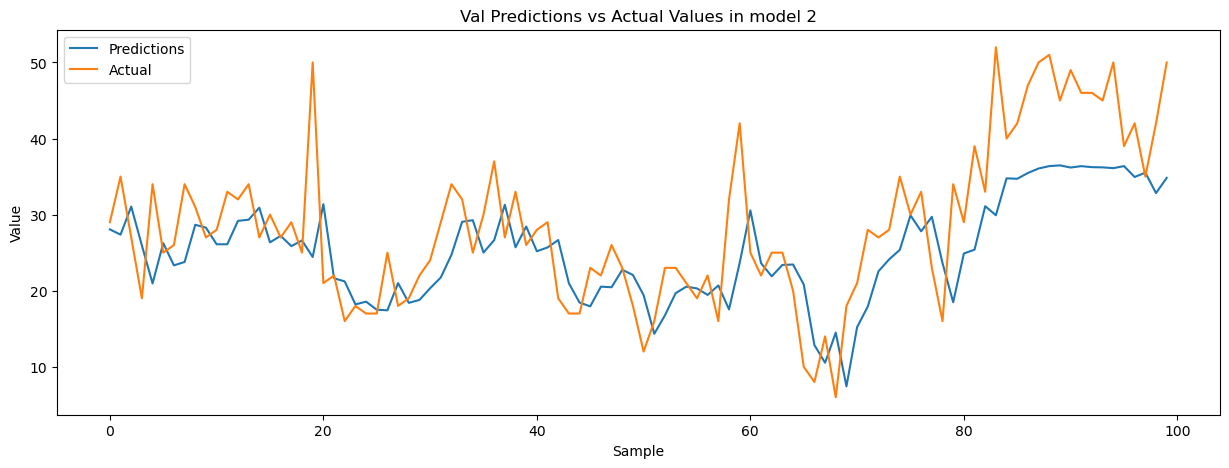

In [69]:
# Limit the number of points to display (for example, the first 100 points)
num_points = 100
val_results_subset = val_results.iloc[:num_points]


# Plot the model predictions and the actual valuess
plt.figure(figsize=(15, 5))
plt.plot(val_results_subset["Val Predictions"], label="Predictions")
plt.plot(val_results_subset["Actual"], label="Actual")

# Add labels and title to the plot
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Val Predictions vs Actual Values in model 2")
plt.legend()
plt.savefig("Val Predictions vs Actual Values in model 2")

# Show the plot
plt.show()

In [70]:
#Checking prediction and actual values for testing data
test_predictions =model2.predict(X_test).flatten()
test_results =pd.DataFrame(data={"Test Predictions": test_predictions, "Actual" :y_test})
test_results

6/6 [==============================] - 0s 2ms/step


,Test Predictions,Actual
0,17.828772,18
1,17.964249,14
2,15.351852,15
3,15.806618,18
4,17.361691,25
...,...,...
180,15.932018,19
181,18.251450,14
182,15.084173,11
183,12.656976,31


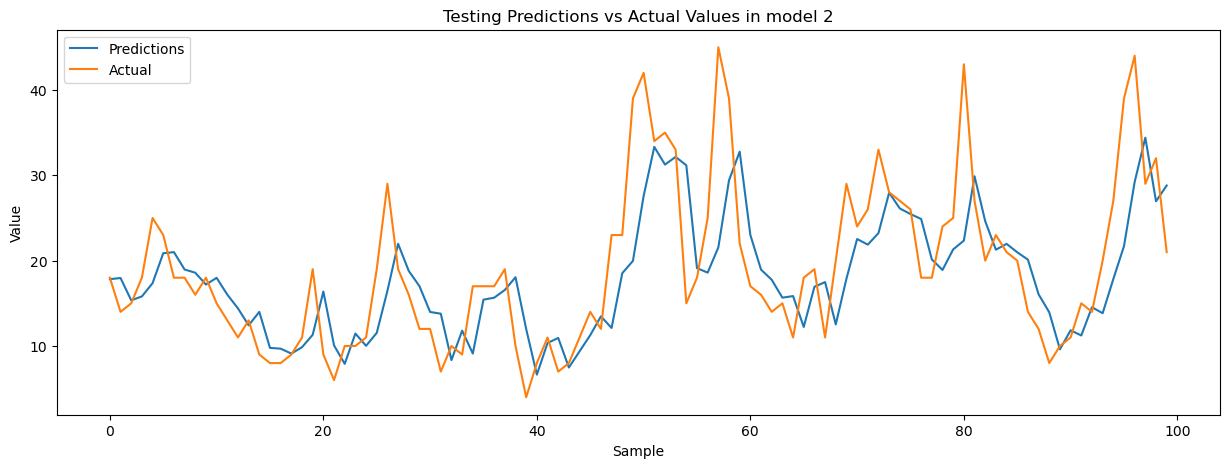

In [71]:
# Limit the number of points to display (for example, the first 100 points)
num_points = 100
test_results_subset = test_results.iloc[:num_points]

# Plot the model predictions and the actual values
plt.figure(figsize=(15, 5))
plt.plot(test_results_subset["Test Predictions"], label="Predictions")
plt.plot(test_results_subset["Actual"], label="Actual")

# Add labels and title to the plot
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Testing Predictions vs Actual Values in model 2")
plt.legend()
plt.savefig("Testing Predictions vs Actual Values in model 2")

# Show the plot
plt.show()
